In [2]:
 
import pandas as pd 
import numpy as np
import yfinance
from IPython.display import HTML
import random
#from ipynb.fs.full.Functions1 import hide_toggle
#from operator import itemgetter 
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
#from mpl_finance import candlestick_ohlc
from mplfinance.original_flavor import candlestick_ohlc
import pandas_datareader as pdr
import datetime as dt
import talib
from itertools import compress
#from ipynb.fs.full.Hide import hide_toggle # this function has to be in the same directory!
# pip install finta!!! the only site that has inverse fisher transform!

In [3]:
symbol ="AAPL TSLA MSFT SPY AMZN BABA GOOGL NFLX AAL PYPL COST"
num_name= symbol.split(' ') 
data_frames_separate = []
for i in num_name:
        ticker = yfinance.Ticker(i)
        data=ticker.history(interval='1d',start="2019-01-01",end="2021-02-05")
        data['Date'] = pd.to_datetime(data.index) # just to crate another column for date!!!
        data['Date'] = data['Date'].apply(mpl_dates.date2num)
        data = data.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
        ohlc_data= data.loc[:,['Date', 'Open', 'High', 'Low', 'Close']].values
        data_frames_separate.append(data)


rsi_High = talib.RSI(data["High"])
rsi_Low= talib.RSI(data["Low"])
#rsi_open = talib.RSI(data["Open"])
rsi_closed= talib.RSI(data["Close"])
       
data_frames_separate[2]

,Date,Open,High,Low,Close
Date,,,,,
2018-12-31,17896.0,98.767836,99.850197,97.939003,99.040863
2019-01-02,17898.0,97.071160,99.216376,96.476349,98.602066
2019-01-03,17899.0,97.607459,97.695222,94.779669,94.974693
2019-01-04,17900.0,97.236930,99.957459,96.466600,99.391899
2019-01-07,17903.0,99.109129,100.698539,98.465567,99.518669
...,...,...,...,...,...
2021-01-29,18656.0,235.990005,238.020004,231.350006,231.960007
2021-02-01,18659.0,235.059998,242.500000,232.429993,239.649994
2021-02-02,18660.0,241.300003,242.309998,238.690002,239.509995


In [4]:
for i in range(len(num_name)):
     data_frames_separate[i]["RsiLow"]= talib.RSI(data_frames_separate[i]["Low"])
     data_frames_separate[i]["RsiHigh"]= talib.RSI(data_frames_separate[i]["High"])
data_frames_separate[5]

,Date,Open,High,Low,Close,RsiLow,RsiHigh
Date,,,,,,,
2018-12-31,17896.0,141.830002,142.020004,136.039993,137.070007,NaN,NaN
2019-01-02,17898.0,134.130005,137.748993,133.029999,136.699997,NaN,NaN
2019-01-03,17899.0,134.270004,134.869995,129.830002,130.600006,NaN,NaN
2019-01-04,17900.0,134.259995,141.080002,133.660004,139.750000,NaN,NaN
2019-01-07,17903.0,140.550003,144.080002,139.009995,143.100006,NaN,NaN
...,...,...,...,...,...,...,...
2021-01-29,18656.0,256.029999,258.899994,252.300003,253.830002,53.267234,52.916667
2021-02-01,18659.0,258.799988,265.000000,255.195007,264.690002,55.338848,56.850608
2021-02-02,18660.0,264.570007,265.000000,254.039993,254.500000,54.304549,56.850608


In [5]:
# only for plotting!
rsi_data=[]
for i in range(len(num_name)):
    rsi_data.append(talib.RSI(data_frames_separate[i]["Close"]))
len(rsi_data)

11

In [6]:
def isSupportRSI(df,i):
  support = df['RsiLow'][i] < df['RsiLow'][i-1]  and df['RsiLow'][i] < df['RsiLow'][i+1] \
  and df['RsiLow'][i+1] < df['RsiLow'][i+2] and df['RsiLow'][i-1] < df['RsiLow'][i-2]

  return support

def isResistanceRSI(df,i):
  resistance = df['RsiHigh'][i] > df['RsiHigh'][i-1]  and df['RsiHigh'][i] > df['RsiHigh'][i+1] \
  and df['RsiHigh'][i+1] > df['RsiHigh'][i+2] and df['RsiHigh'][i-1] > df['RsiHigh'][i-2] 

  return resistance

In [7]:
levels = [[] for i in range(len(num_name))]

for a in range(len(levels)):
    for i in range(2,data_frames_separate[a].shape[0]-2):
        if isSupportRSI(data_frames_separate[a],i):
            levels[a].append((i,data_frames_separate[a]['RsiLow'][i]))
        elif isResistanceRSI(data_frames_separate[a],i):
            levels[a].append((i,data_frames_separate[a]['RsiHigh'][i]))
len(levels)


11

In [8]:
def plotRsiSupportResistance(num):
    
  fig = plt.figure(figsize=(12,8))
  gs = gridspec.GridSpec(2, 1, height_ratios = [2,1]) 
  ax_rsi1= plt.subplot(gs[0])    
  plt.title(num_name[num])

  candlestick_ohlc(ax_rsi1,data_frames_separate[num].values,width=0.6, \
                   colorup='green', colordown='red', alpha=0.8)
    
  ax_rsi= plt.subplot(gs[1])
 
  ax_rsi.plot(data.index, [75] * len(data.index))
  ax_rsi.plot(data.index, [30] * len(data.index))
  ax_rsi.plot(data.index, rsi_data[num])

  legend_labels= ["overbought", "oversold","rsi"]
  ax_rsi.legend(legend_labels,loc = 2)

  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax_rsi.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()
  fig.tight_layout()
  ax_rsi1.grid()
  #ax_rsi.grid()
# Removing the date labels and ticks from the price subplot:
  ax_rsi1.get_xaxis().set_visible(False)
# Removing the gap between the plots:
  fig.subplots_adjust(hspace=0)
# Adding a horizontal line at the zero level in the ROC subplot:
  ax_rsi.axhline(20, color = (.5, .5, .5), linestyle = '--', alpha = 0.5)
# We can add labels to both vertical axis:
  ax_rsi1.set_ylabel("Price ($)")
  ax_rsi.set_ylabel("% RSI")

  for level in levels[num]:
     plt.hlines(level[1],xmin=data_frames_separate[num]['Date'][level[0]],\
               xmax=max(data_frames_separate[num]['Date']),colors='blue')


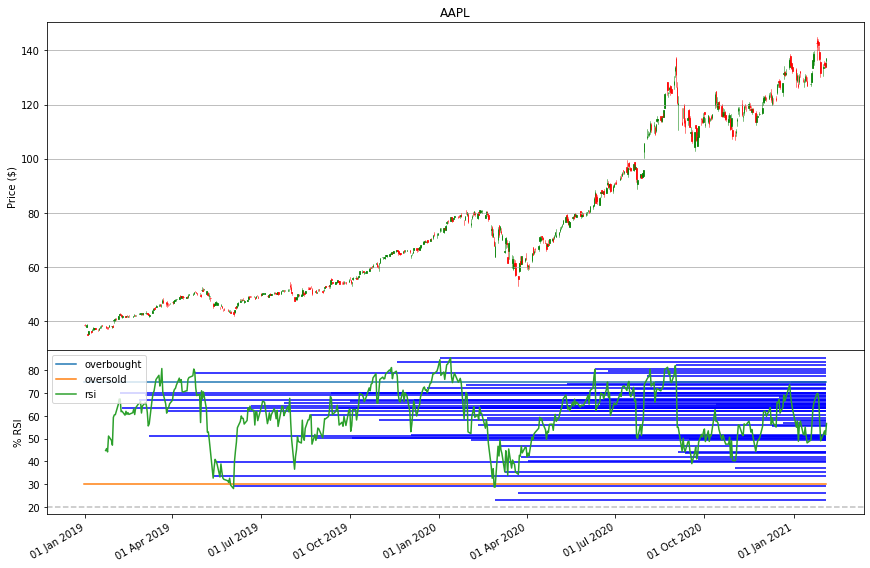

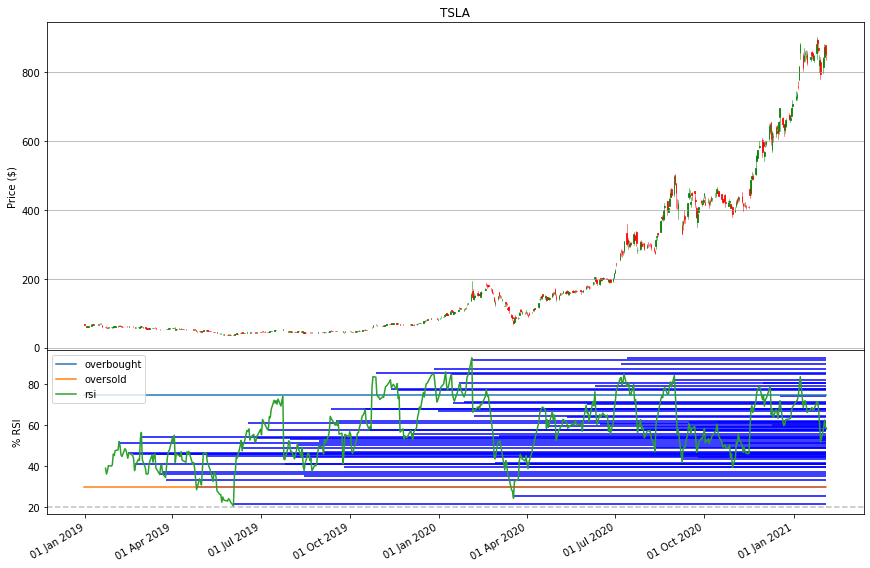

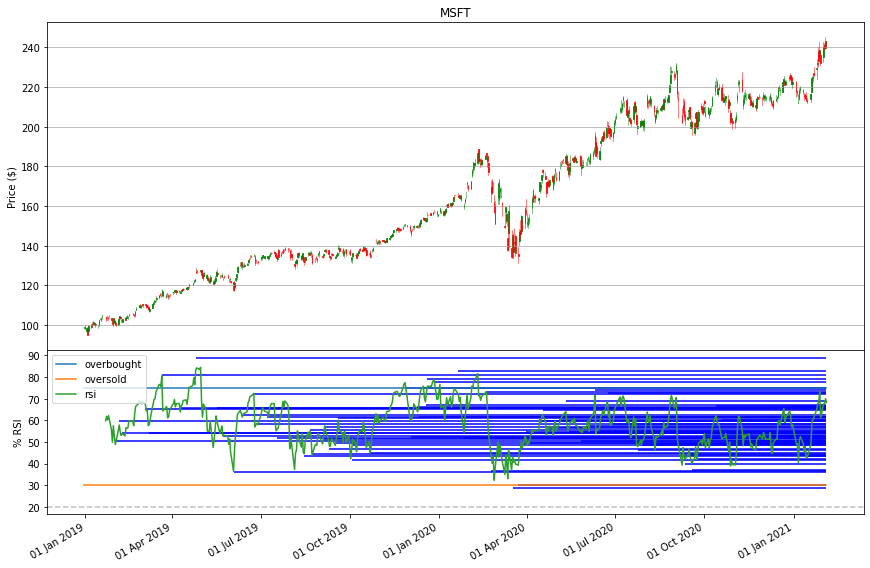

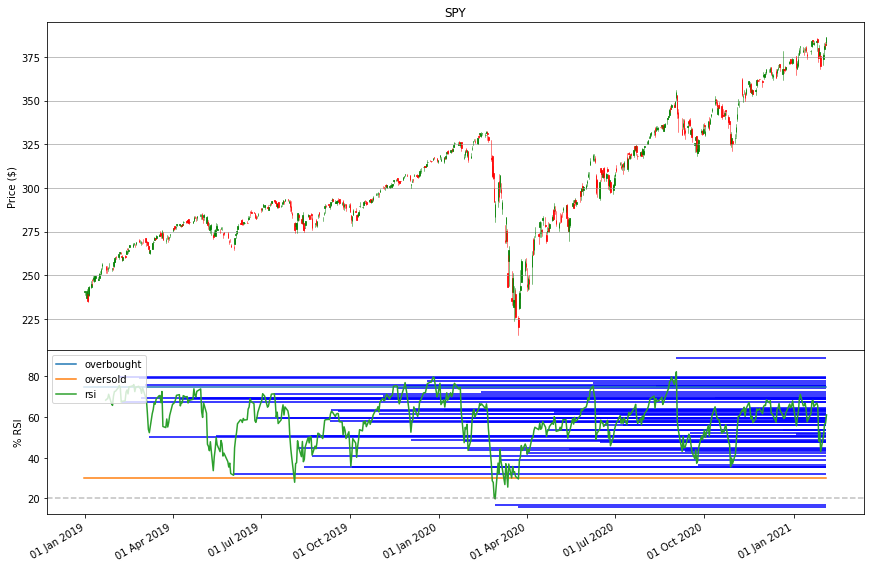

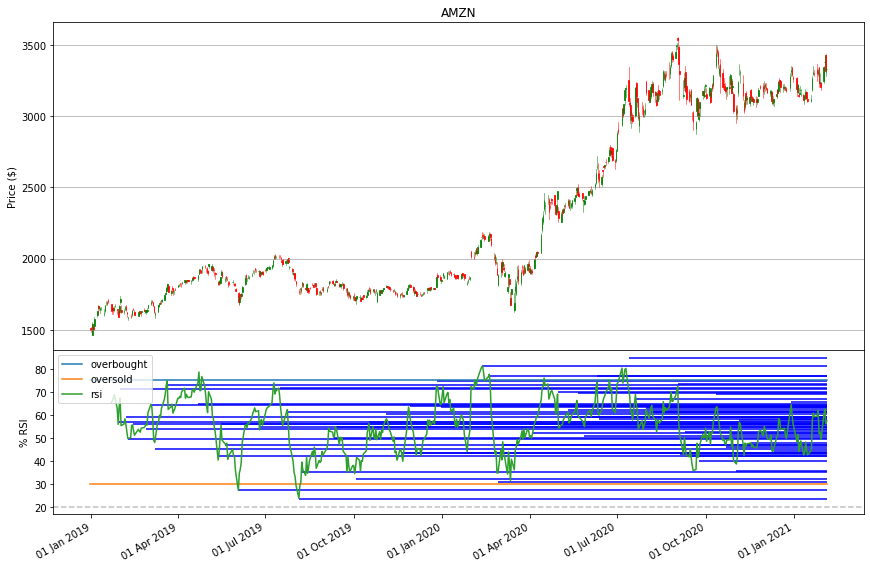

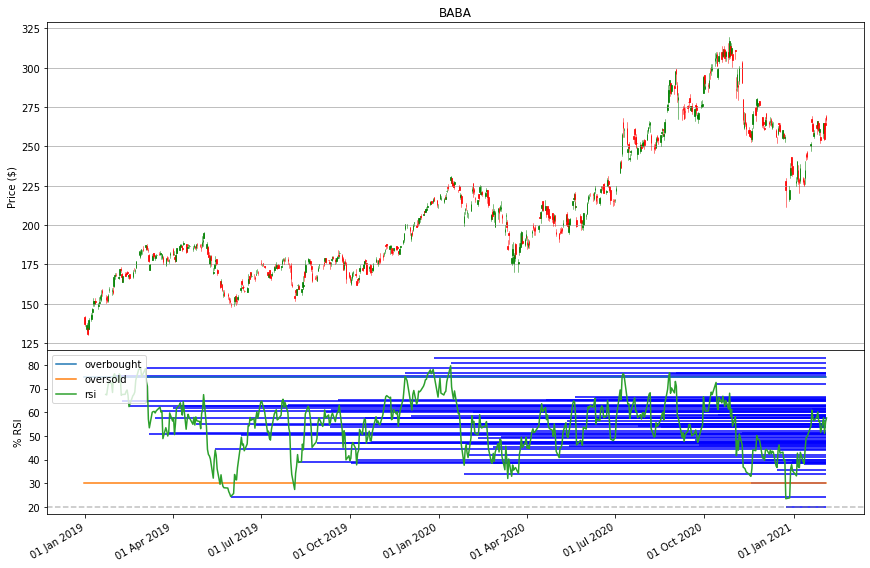

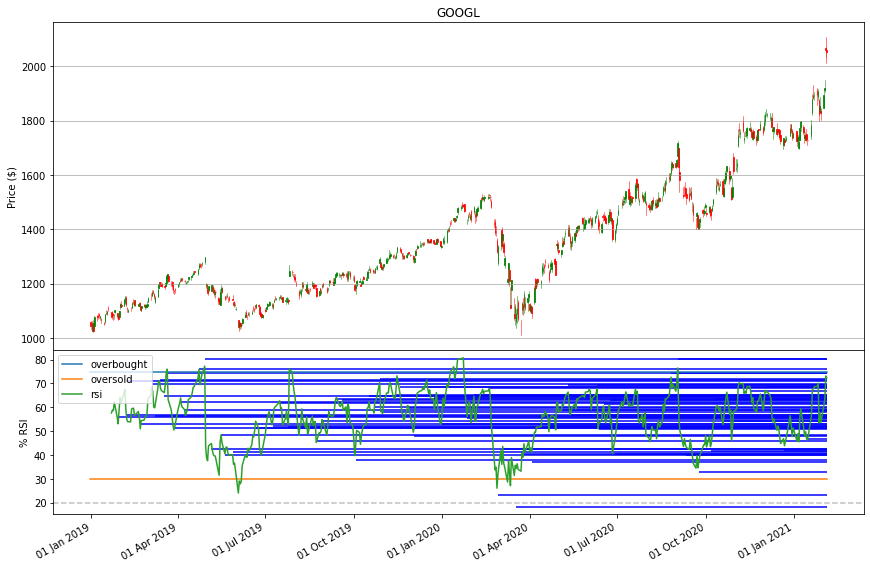

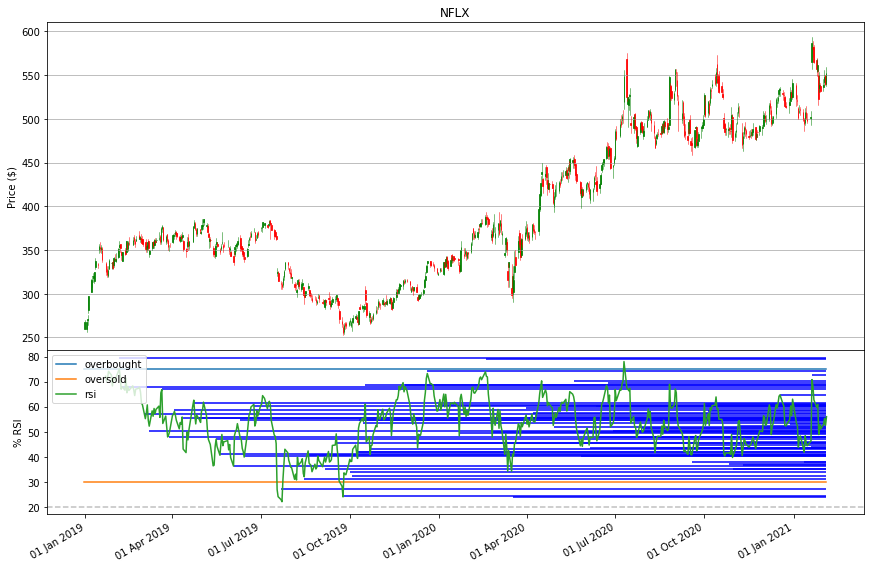

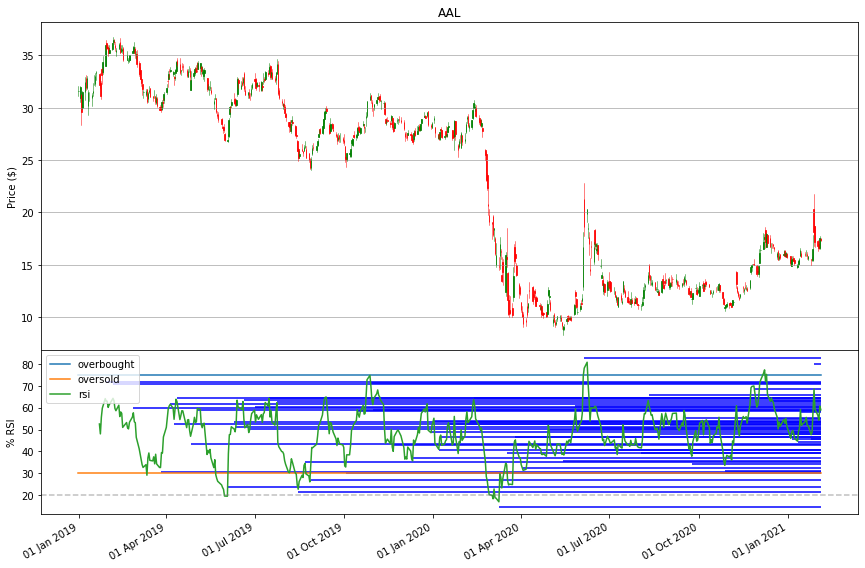

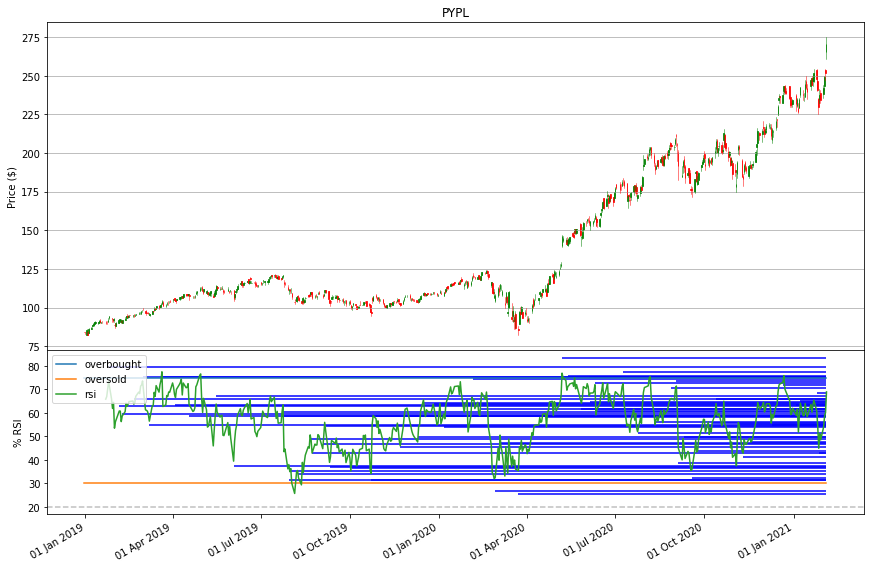

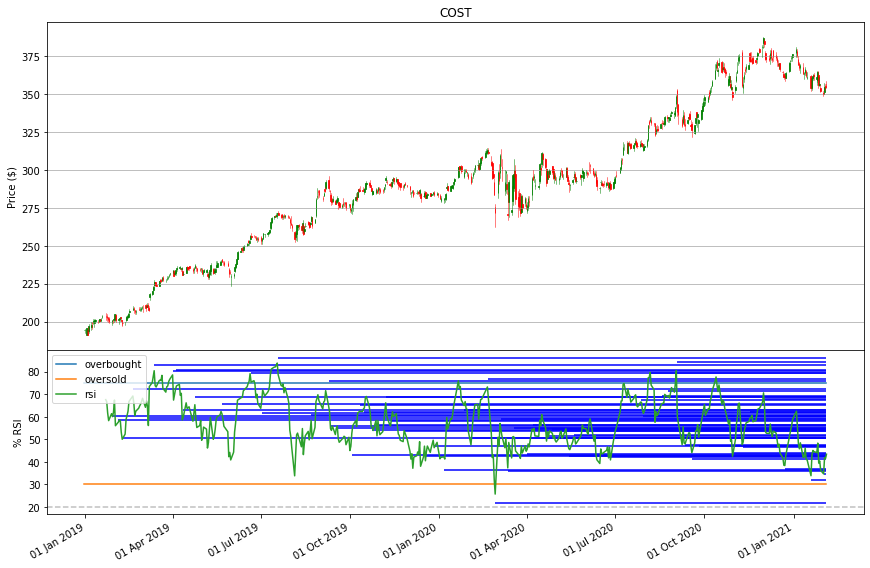

In [9]:
for i in range(len(num_name)):
    plotRsiSupportResistance(i)

In [39]:
# s=[]
# for num in range(len(num_name)):
#     s.append(np.mean(data_frames_separate[num]['RsiHigh'] - data_frames_separate[num]['RsiLow']))
   
# s

[0.43327555571572113,
 -0.5132728153768603,
 0.24547124000094583,
 1.06426771710981,
 -0.03727540942712963,
 0.08933013103881446,
 -0.002583896495174225,
 -0.2533164243154273,
 -0.09690446252904263,
 0.6435024084953312,
 0.5993245781143614]

In [53]:
#  s= [abs(i)*10 for i in s]
s = 7 # make them all al least 5 !!!

In [54]:
# it is crazy how certain "S"values can be negative!! especially for tesla 

In [55]:
def isFarFromLevel(l,m):

  return np.sum([abs(l-x) < s  for x in levels[m]]) == 0

In [56]:
levels

[[(25, 69.90475075258425),
  (46, 50.987200482622995),
  (224, 83.64552569197508),
  (298, 35.26393604782012)],
 [(25, 69.90475075258425),
  (46, 50.987200482622995),
  (224, 83.64552569197508),
  (298, 35.26393604782012)],
 [(25, 69.90475075258425),
  (46, 50.987200482622995),
  (224, 83.64552569197508),
  (298, 35.26393604782012)],
 [(25, 69.90475075258425),
  (46, 50.987200482622995),
  (224, 83.64552569197508),
  (298, 35.26393604782012)],
 [(25, 69.90475075258425),
  (46, 50.987200482622995),
  (224, 83.64552569197508),
  (298, 35.26393604782012)],
 [(25, 69.90475075258425),
  (46, 50.987200482622995),
  (224, 83.64552569197508),
  (298, 35.26393604782012)],
 [(25, 69.90475075258425),
  (46, 50.987200482622995),
  (224, 83.64552569197508),
  (298, 35.26393604782012)],
 [(25, 69.90475075258425),
  (46, 50.987200482622995),
  (224, 83.64552569197508),
  (298, 35.26393604782012)],
 [(25, 69.90475075258425),
  (46, 50.987200482622995),
  (224, 83.64552569197508),
  (298, 35.2639360478

In [57]:
levels = [[] for i in range(len(num_name))]
for num in range(len(levels)):
    for i in range(2,data_frames_separate[0].shape[0]-2):
            if isSupportRSI(data_frames_separate[0],i):
                l = data_frames_separate[0]['RsiLow'][i]

                if isFarFromLevel(l,num):
                      levels[num].append((i,l))

            elif isResistanceRSI(data_frames_separate[0],i):
                l = data_frames_separate[0]['RsiHigh'][i]

                if isFarFromLevel(l,num):
                      levels[num].append((i,l))
len(levels)

11

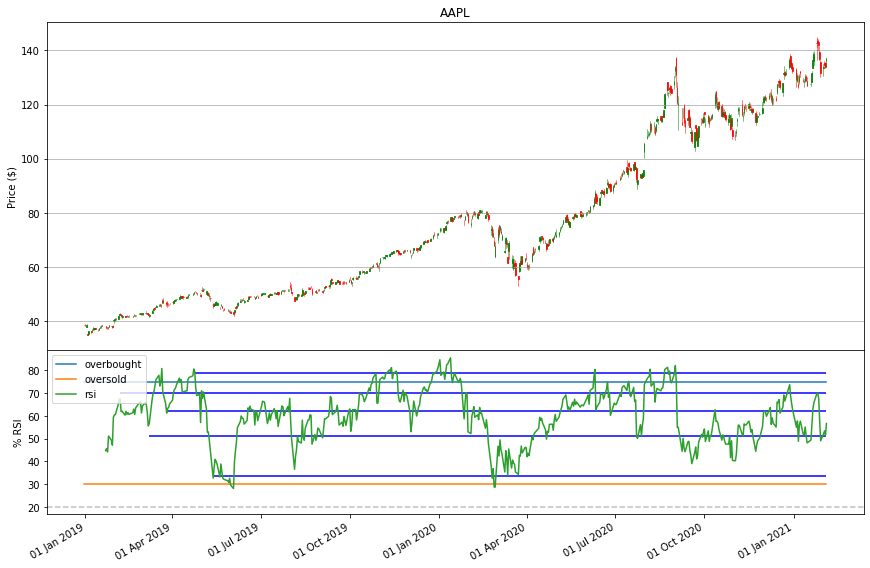

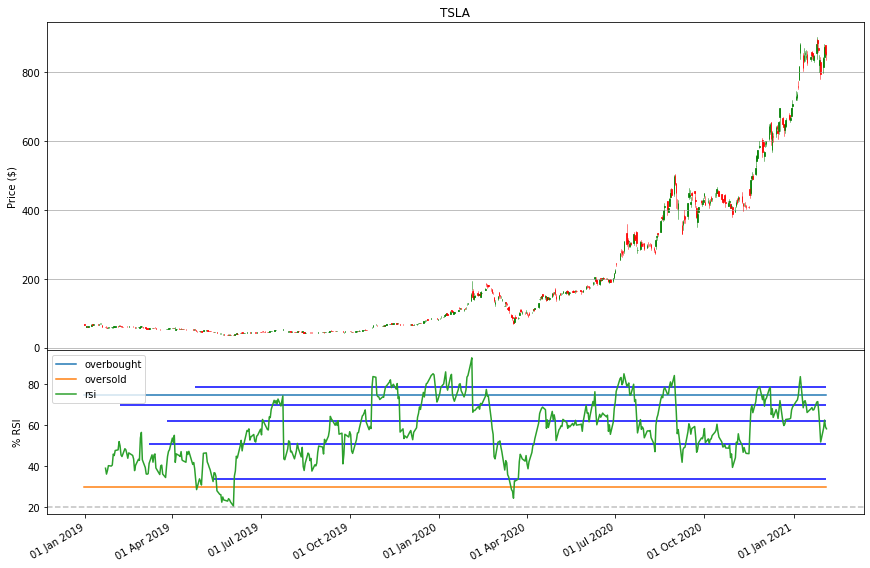

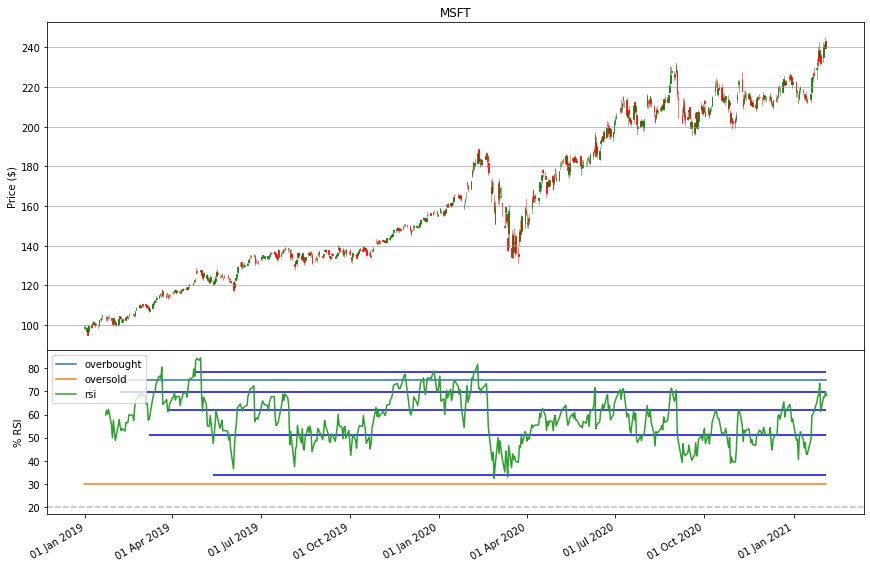

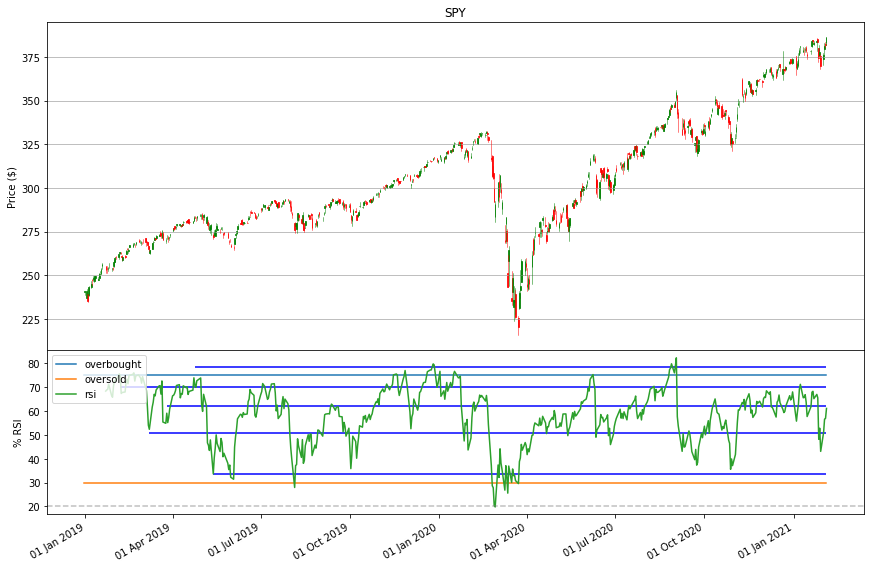

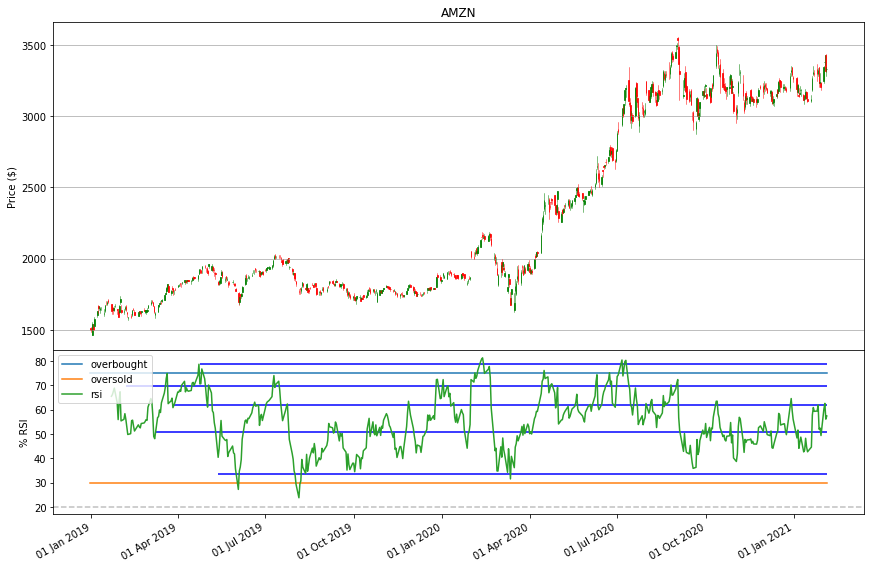

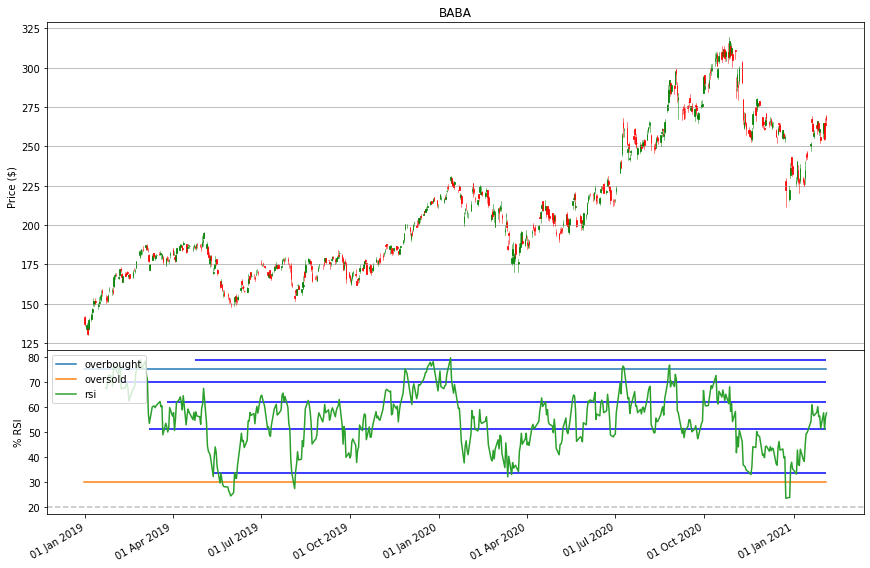

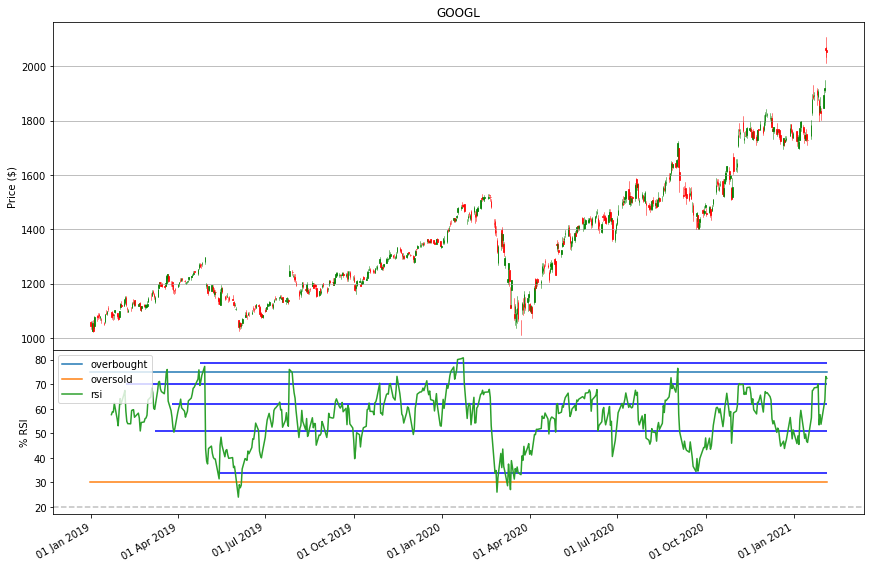

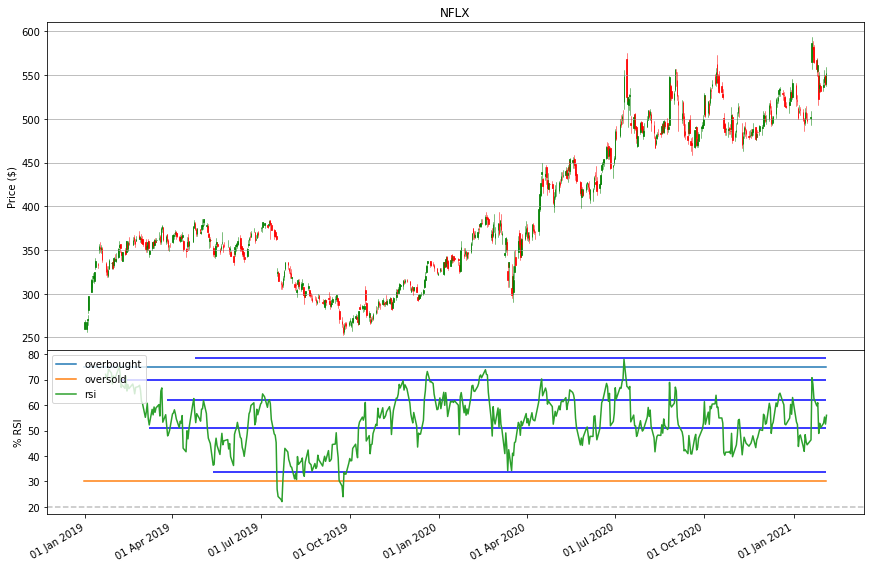

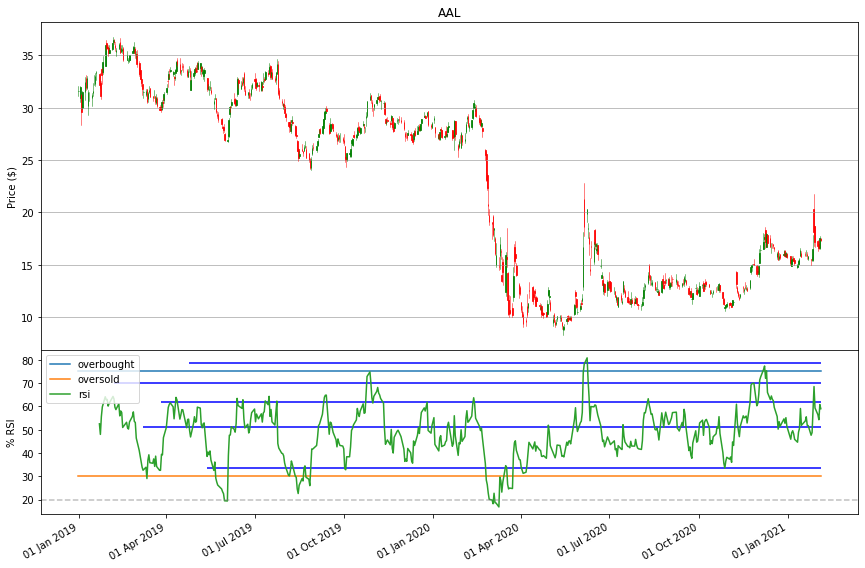

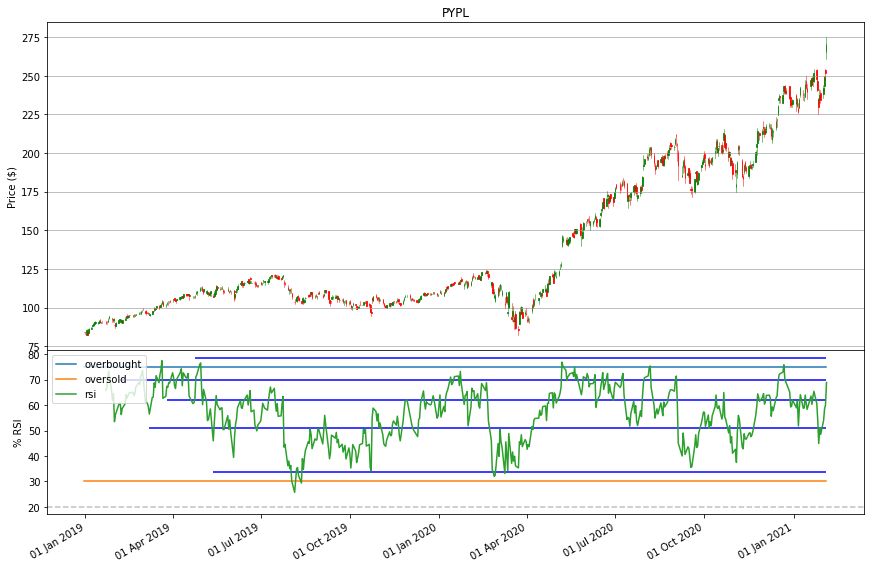

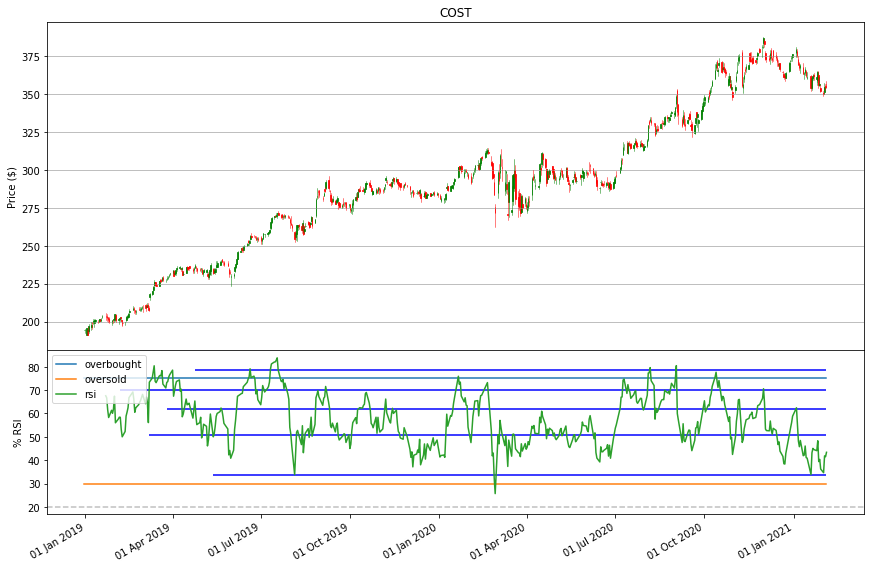

In [58]:
for i in range(len(num_name)):
    plotRsiSupportResistance(i)